## **Multi-Regression Model**: Smart Energy Consumption Prediction and Optimization 

### Project Overview
This project aims to predict energy consumption using historical electrical usage data and suggest optimization strategies. By analyzing the provided dataset, I am going to  build a regression model to forecast future energy consumption and offer recommendations for energy savings.

With increasing energy costs and growing concerns about environmental sustainability, it is crucial for residential buildings to optimize their energy usage. Efficient energy consumption not only reduces operational costs but also minimizes the environmental impact. Despite the availability of smart meters and energy management systems, many buildings still struggle to predict and manage their energy consumption effectively.



## Problem Statement

The primary objective of this project is to develop a predictive model that accurately forecasts energy consumption for residential buildings based on historical energy usage data particularly the sub-metering metrics. By leveraging data on global active power, global reactive power, voltage, global intensity, and sub-metering metrics, the model aims to provide actionable insights into energy usage patterns.


## Importing libraries 

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
import warnings 
import matplotlib
matplotlib.rcParams['figure.figsize'] = 10,6
import datetime
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
%matplotlib inline

## Loading Data

In [10]:
df = pd.read_csv('household_power_consumption.csv', delimiter = ';', low_memory = False)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [11]:
# checking the amount of data available
df.shape


(2075259, 9)

## Data Cleaning

#### data cleaning function

In [14]:
def wrangle(path):
    df = pd.read_csv(path, delimiter = ';' , low_memory = False)
    # drop missing values
    df.dropna(inplace = True)
     
    # Convert 'Date' and 'Time' to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df['Time'] = pd.to_datetime(df['Time'])
    
    #Feature Engineering on 'Date' and 'Time'
    df["month"] = df['Date'].dt.month
    df['hour'] = df['Time'].dt.hour
    df['weekday'] = df['Date'].dt.dayofweek+1
    
    # Convert numeric columns to float
    numeric_cols = [
        'Global_active_power',
        'Global_reactive_power',
        'Voltage',
        'Global_intensity',
        'Sub_metering_1',
        'Sub_metering_2',
        'Sub_metering_3'
    ]
    #Change data types from string to float
    df[numeric_cols] = df[numeric_cols].replace('?', 0).astype(float)

    
    return df
    

    

In [15]:
# using the wrangle function to clean the data
df = wrangle('household_power_consumption.csv')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,month,hour,weekday
0,2006-12-16,2024-09-05 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,12,17,6
1,2006-12-16,2024-09-05 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,12,17,6
2,2006-12-16,2024-09-05 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,12,17,6
3,2006-12-16,2024-09-05 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,12,17,6
4,2006-12-16,2024-09-05 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,12,17,6


In [16]:
# checking the datatypes after cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2049280 entries, 0 to 2075258
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   datetime64[ns]
 1   Time                   datetime64[ns]
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
 9   month                  int32         
 10  hour                   int32         
 11  weekday                int32         
dtypes: datetime64[ns](2), float64(7), int32(3)
memory usage: 179.8 MB


In [17]:
#checking missing values
df.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
month                    0
hour                     0
weekday                  0
dtype: int64

In [18]:
# descriptive statistics 
df.describe()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,month,hour,weekday
count,2049280,2049280,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,2008-12-01 13:00:00.309181952,2024-09-05 11:59:44.088559104,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,6.454433e+00,1.150391e+01,3.989276e+00
min,2006-12-16 00:00:00,2024-09-05 00:00:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,2007-12-10 00:00:00,2024-09-05 05:59:00,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,5.000000e+00,2.000000e+00
50%,2008-11-30 00:00:00,2024-09-05 12:00:00,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,1.200000e+01,4.000000e+00
75%,2009-11-23 00:00:00,2024-09-05 18:00:00,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,9.000000e+00,1.800000e+01,6.000000e+00
max,2010-11-26 00:00:00,2024-09-05 23:59:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.200000e+01,2.300000e+01,7.000000e+00
std,NaN,NaN,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,3.423209e+00,6.925189e+00,1.997633e+00


In [19]:
#checking duplicates
df.duplicated().sum()

0

## Exploratory Analysis

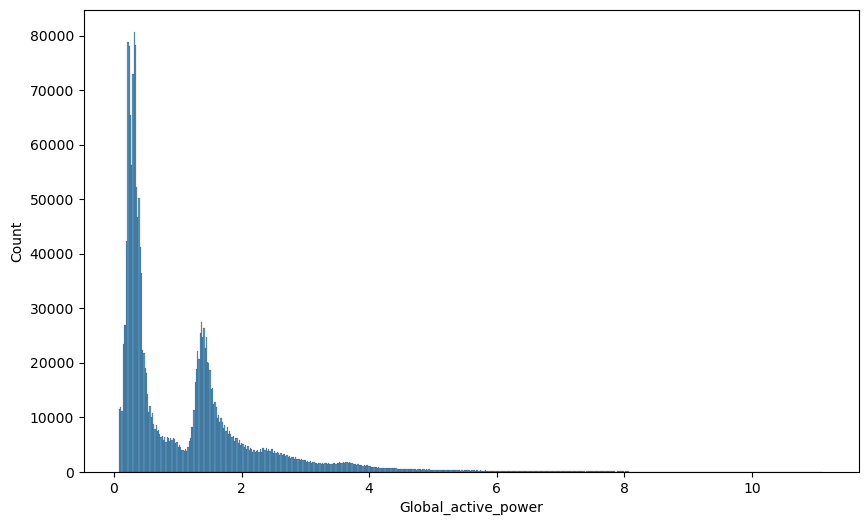

In [21]:
#Univariate analysis (checking the distribution of Global active power) 
sns.histplot(df['Global_active_power']);

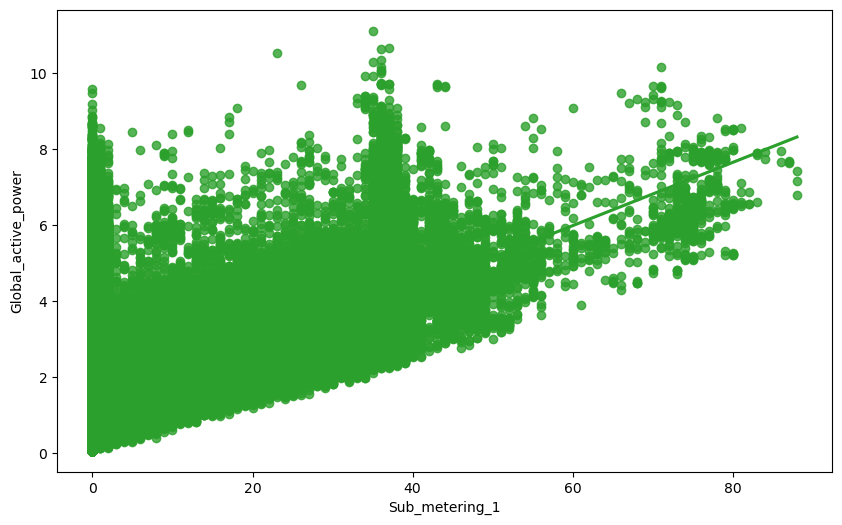

In [22]:
#plotting global active power vs sub metering 1 correlation
sns.regplot(x= 'Sub_metering_1', y= 'Global_active_power', label = 'Sub_metering_1', color ='C2' , data=df);

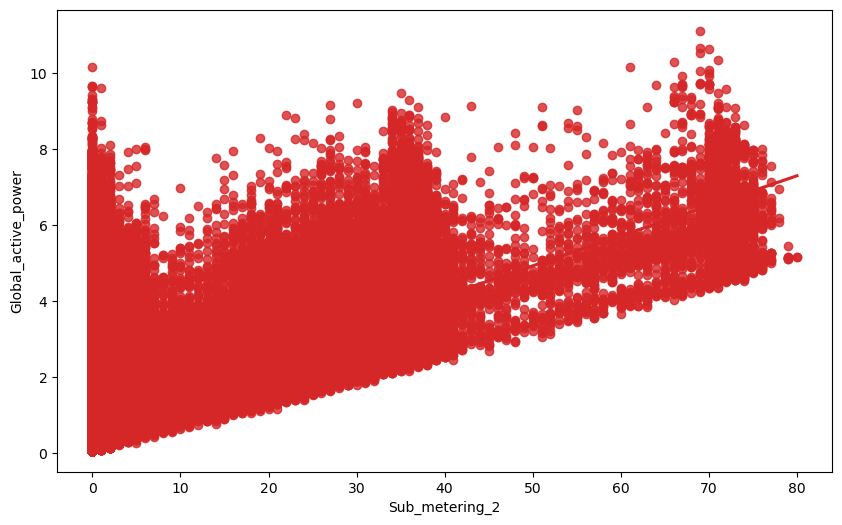

In [23]:
#plotting global active power vs sub metering 2 correlation
sns.regplot(x='Sub_metering_2', y= 'Global_active_power' , label ='Sub_metering_2',color = 'C3', data=df);


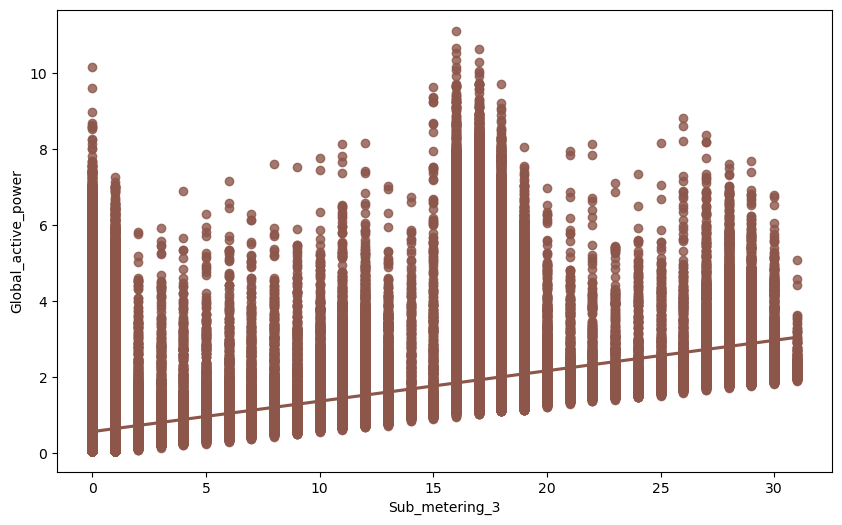

In [24]:
#plotting global active power vs sub metering 3 correlation
sns.regplot(x='Sub_metering_3', y= 'Global_active_power' ,label = 'Sub_metering_3', color = "C5", data=df);

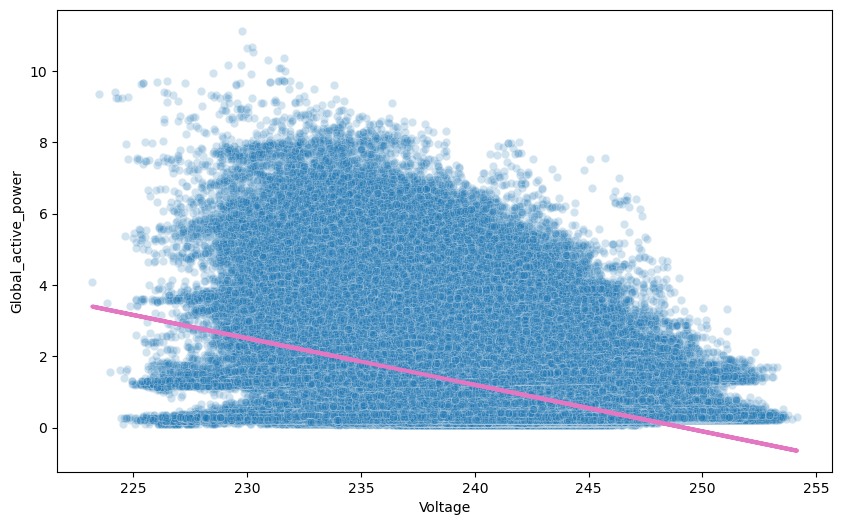

In [25]:
#plotting global active power vs voltage correlation
sns.scatterplot(x='Voltage', y= 'Global_active_power', alpha = 0.2, data=df)
z = np.polyfit(df['Voltage'], df['Global_active_power'], 1)
p = np.poly1d(z)

plt.plot(df['Voltage'], p(df['Voltage']), color = 'C6', linewidth = 3);

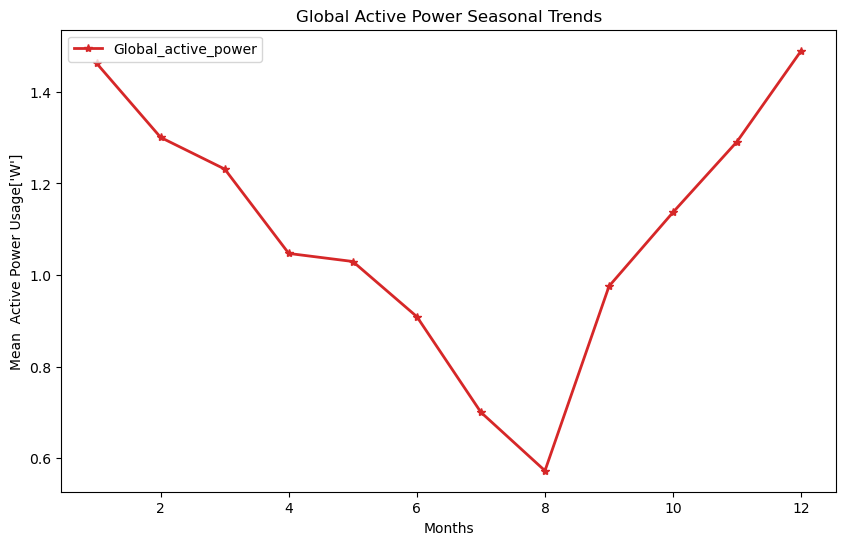

In [26]:
#checking seasonal trends of electricity use 

#extract month from date
df["month"] = df['Date'].dt.month

# Global active power vs month
df.groupby('month')['Global_active_power'].mean().plot(color = "C3", marker = '*', linewidth = 2)
plt.xlabel('Months')
plt.ylabel("Mean  Active Power Usage['W']")
plt.title("Global Active Power Seasonal Trends")
plt.legend();



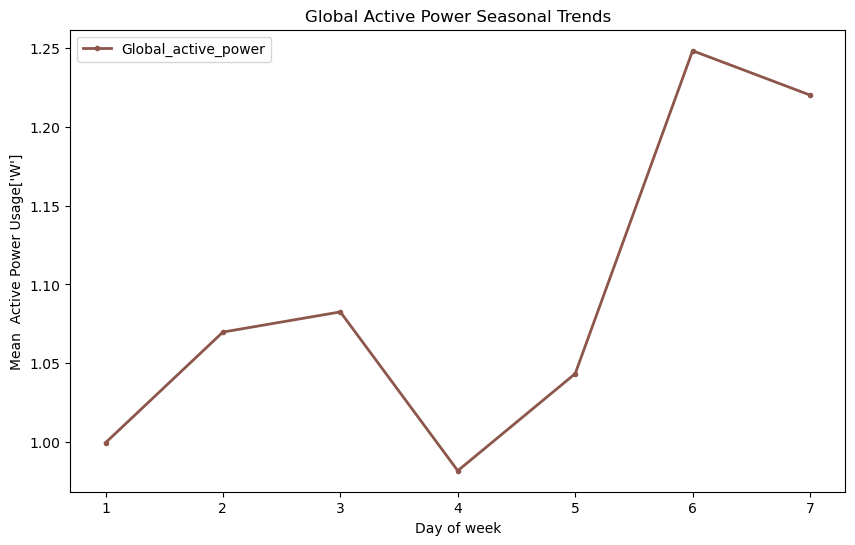

In [27]:
#checking weekly usage 

#edxtracting 'weekday' from the Time column
df['weekday'] = df['Date'].dt.dayofweek+1


#Global active power usage vs hour
df.groupby('weekday')['Global_active_power'].mean().plot(color = "C5", marker = '.', linewidth = 2)
plt.xlabel('Day of week')
plt.ylabel("Mean  Active Power Usage['W']")
plt.title("Global Active Power Seasonal Trends")
plt.legend();

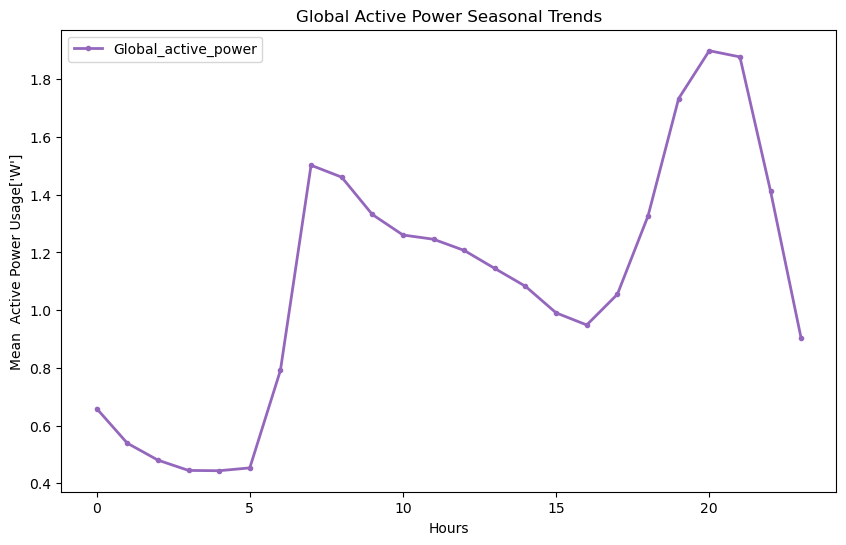

In [28]:
#checking hourly usage 

#extracting 'hour' from the Time column
df['hour'] = df['Time'].dt.hour

#Global active power usage vs hour
df.groupby('hour')['Global_active_power'].mean().plot(color = "C4", marker = '.', linewidth=2)
plt.xlabel('Hours')
plt.ylabel("Mean  Active Power Usage['W']")
plt.title("Global Active Power Seasonal Trends")
plt.legend();

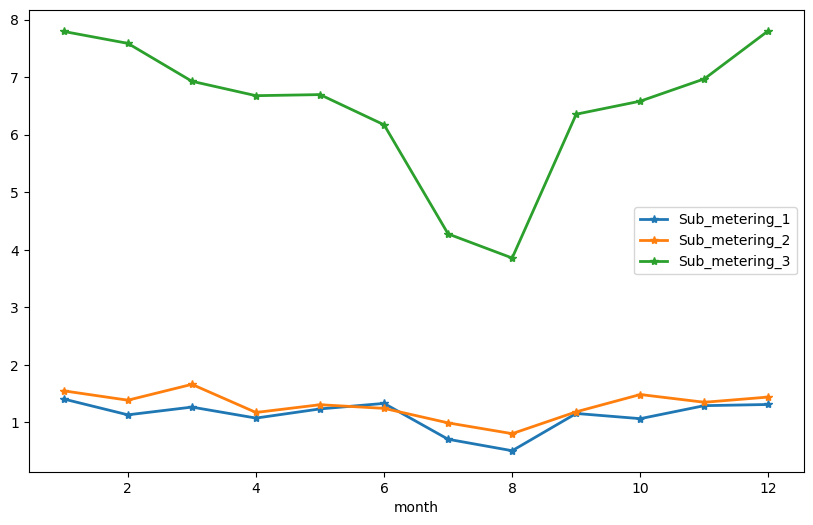

In [29]:
#analysing submetering seasonal trends 
df.groupby('month')[['Sub_metering_1',	'Sub_metering_2',	'Sub_metering_3']].mean().plot(marker = '*', linewidth = 2);

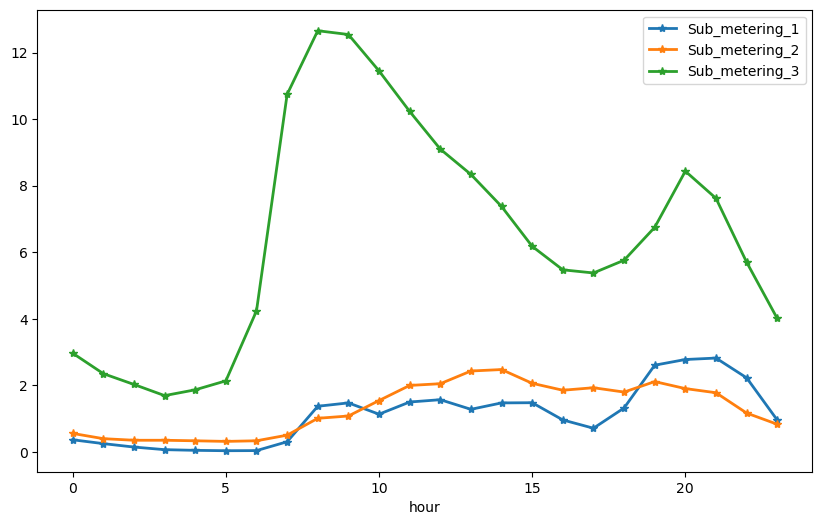

In [30]:
#analysing submetering daily  trends 
df.groupby('hour')[['Sub_metering_1',	'Sub_metering_2',	'Sub_metering_3']].mean().plot(marker = '*', linewidth = 2);

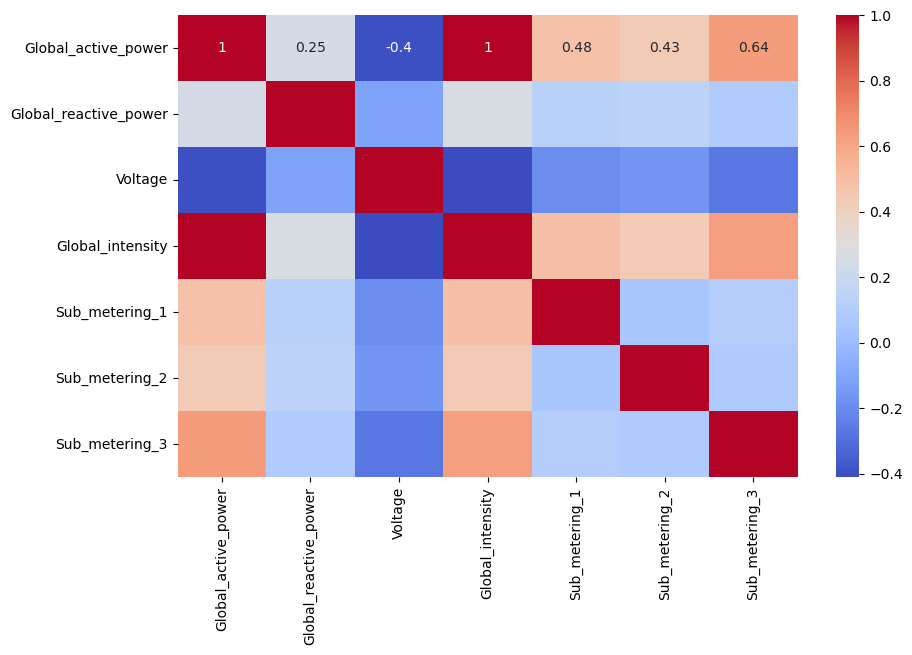

In [31]:
# Calculating correlation of the variables
corr = df.drop(columns =['Date', 'Time', 'month','hour', 'weekday']).corr()

# creating a heatmap of the correlation
sns.heatmap(corr, annot = True, cmap = "coolwarm");



## Model Building

### Splitting  Data 

In [34]:
# target variable and features selection
target = 'Global_active_power'
features = ['Sub_metering_1',	'Sub_metering_2',	'Sub_metering_3']
y = df[target]
X = df[features]

In [35]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.20, random_state = 42)
print(f"X_train is {X_train.shape}")
print(f"y_train is {y_train.shape}")
print(f"X_test is {X_test.shape}")
print(f"y_test is {y_test.shape}")

X_train is (1639424, 3)
y_train is (1639424,)
X_test is (409856, 3)
y_test is (409856,)


## Data Preprosessing

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Training the model

In [39]:
#Instantiating the model
lr_model = LinearRegression( )

# fitting the model
lr_model.fit(X_train_scaled ,y_train)


LinearRegression()

In [40]:
lr_model.score(X_test_scaled ,y_test)

0.7211728000410755

### Making predictions  with the model

In [42]:
# predicting on training data 
y_train_pred = lr_model.predict(X_train_scaled)
y_train_pred[:5]

array([0.53471454, 0.5393118 , 0.46822795, 1.81882105, 0.53471454])

In [43]:
#predicting on test data
y_test_pred = lr_model.predict(X_test_scaled)
y_train_pred[:5]

array([0.53471454, 0.5393118 , 0.46822795, 1.81882105, 0.53471454])

### Evaluating model performance

In [45]:
# Evaluating training data 
lr_train_MSE =mean_squared_error(y_train, y_train_pred)
lr_train_MAE =  mean_absolute_error(y_train, y_train_pred)
lr_train_R2 = r2_score(y_train, y_train_pred)
print(f"The mean squared error value is {lr_train_MSE}")
print(f"The mean absolute error value is {lr_train_MAE}")
print(f"The r2 score value is {lr_train_R2}")

The mean squared error value is 0.31538574868367125
The mean absolute error value is 0.3816319943341263
The r2 score value is 0.7174854153260943


In [46]:
#Evaluating test data
lr_test_MSE =mean_squared_error(y_test, y_test_pred)
lr_test_MAE =  mean_absolute_error(y_test, y_test_pred)
lr_test_R2 = r2_score(y_test, y_test_pred)
print(f"The mean squared error value is {lr_test_MSE}")
print(f"The mean absolute error value is {lr_test_MAE}")
print(f"The r2 score value is {lr_test_R2}")


The mean squared error value is 0.3133860139731703
The mean absolute error value is 0.3811362116776518
The r2 score value is 0.7211728000410755


In [47]:
# Creating a DataFrame of the evaluation
lr_results = pd.DataFrame(['Linear regression', lr_train_MSE, lr_train_MAE, lr_train_R2, lr_test_MSE, lr_test_MAE, lr_test_R2]).transpose()
lr_results.columns = ['Model', 'Training mse', 'Training mae', 'Training r2', 'Prediction mse', 'Prediction mae', 'Prediction r2']
lr_results

,Model,Training mse,Training mae,Training r2,Prediction mse,Prediction mae,Prediction r2
0,Linear regression,0.315386,0.381632,0.717485,0.313386,0.381136,0.721173


## Extracting results

In [49]:
#extracting coefficients
lr_model.coef_

array([0.42908876, 0.38629394, 0.5996458 ])

In [50]:
#extracting the intercept
lr_model.intercept_

1.091693455750312

# Random Forest Model

In [52]:
#importing RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor


## Training the Model

In [54]:
#instatiate the random forest regressor
rf_model = RandomForestRegressor(max_depth = 2, random_state=42)

#fit the model
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=2, random_state=42)

### Making predictions

In [56]:
#making predictions on training data
rf_train_pred = rf_model.predict(X_train_scaled)
print(rf_train_pred[:5])

[0.57027975 0.57027975 0.57027975 1.93326543 0.57027975]


In [57]:
#making predictions on test data
rf_test_pred = rf_model.predict(X_test_scaled)
print(rf_test_pred[:5])

[1.93326543 0.57027975 0.57027975 0.57027975 1.93326543]


### Evaluating the model 


In [59]:
#Evaluating training data
rf_train_MSE =mean_squared_error(y_train, rf_train_pred)
rf_train_MAE =  mean_absolute_error(y_train, rf_train_pred)
rf_train_r2 = r2_score(y_train, rf_train_pred)
print("training mse",rf_train_MSE)
print("training mae",rf_train_MAE)
print("training r2 is",rf_train_r2 )

training mse 0.4694227867428522
training mae 0.46433691005461264
training r2 is 0.5795029287574449


In [60]:
#Evaluating test data
rf_test_MSE =mean_squared_error(y_test, rf_test_pred)
rf_test_MAE =  mean_absolute_error(y_test, rf_test_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)
print("test mse",rf_test_MSE)
print("test mae",rf_test_MAE)
print("test r2 is",rf_test_r2 )

test mse 0.4709692406890648
test mae 0.4641617298553178
test r2 is 0.5809671497996229


## Combining results of the two models

In [62]:
rf_results = pd.DataFrame(['Random Forest Regressor', rf_train_MSE, rf_train_MAE, rf_train_r2, rf_test_MSE, rf_test_MAE, rf_test_r2]).transpose()
rf_results.columns = ['Model', 'Training mse', 'Training mae', 'Training r2', 'Prediction mse', 'Prediction mae', 'Prediction r2']

In [63]:
#concatenate results evaluations
df_combined_results =  pd.concat([lr_results, rf_results], axis = 0).reset_index(drop = True)
df_combined_results

,Model,Training mse,Training mae,Training r2,Prediction mse,Prediction mae,Prediction r2
0,Linear regression,0.315386,0.381632,0.717485,0.313386,0.381136,0.721173
1,Random Forest Regressor,0.469423,0.464337,0.579503,0.470969,0.464162,0.580967


# Results

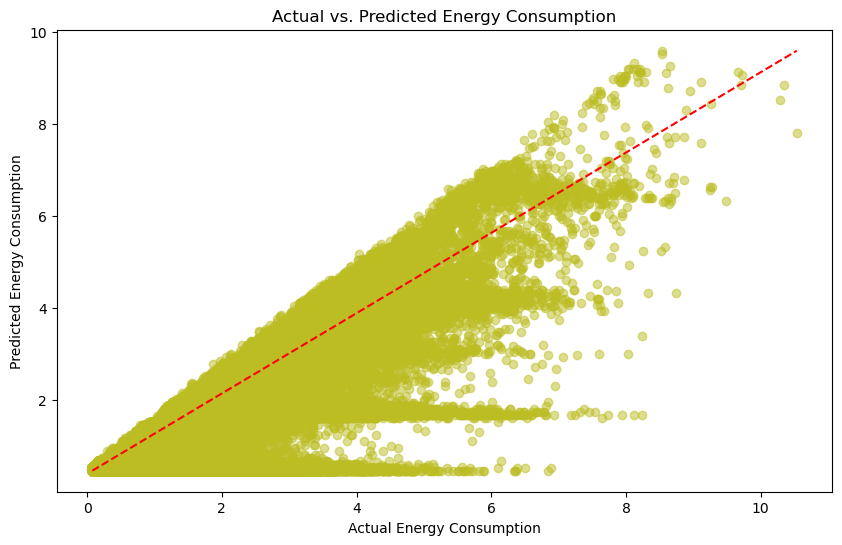

In [65]:
#plotting Actual vs Predicted outcomes 

plt.scatter(y_test, y_test_pred, alpha=0.5, color = 'C8')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.title('Actual vs. Predicted Energy Consumption')
plt.plot([y_test.min(), y_test.max()], [y_test_pred.min(), y_test_pred.max()], 'r--')
plt.show()


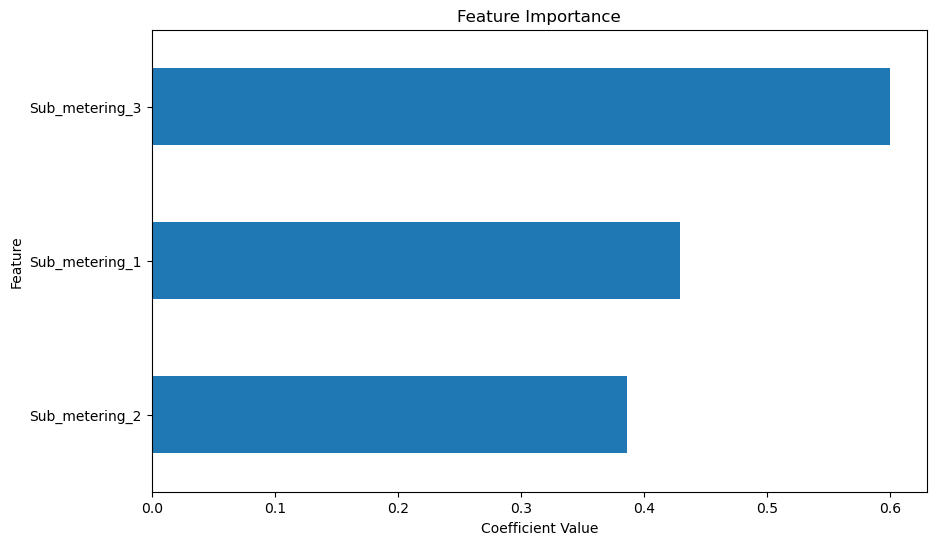

In [66]:
#plotting feature importance 
feature_importance = pd.Series(lr_model.coef_, index=X.columns)
feature_importance.sort_values().plot(kind='barh', figsize=(10,6))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


## Insights



# Explanation

**Sub_metering_1:** Measures the energy usage of the household's kitchen appliances. It’s typically connected to appliances like dishwashers, refrigerators, and microwaves.
**Sub_metering_2:** Records the energy consumption of the household's laundry room, covering appliances such as washing machines, dryers, and possibly other small appliances in that area.

**Sub_metering_3:** Captures the energy usage of the heating, ventilation, and air conditioning (HVAC) systems, which often consume a significant amount of energy.

In [132]:
def Global_active_power(Sub_metering_1, Sub_metering_2, Sub_metering_3):
    Global_active_power = 1.091693455750312 + 0.42908876 * Sub_metering_1 + 0.38629394 * Sub_metering_2 + 0.5996458 * Sub_metering_3
    return Global_active_power

# Call the function with the desired values
result = Global_active_power(200, 200, 200)
print(f"This means if 3 appliances of 200 Watts are connected they will require '{result}' Watts of power")

This means if 3 appliances of 200 Watts are connected they will require '284.0973934557503' Watts of power


**Given the above explanations here are some of the insights derived from the analysis**

**Observations**

- Seasonal Trends: Global active power consumption peaks in January and December, while the lowest usage is observed in August.
- Weekly Patterns: Power consumption is higher on weekends compared to weekdays.
- Hourly Trends: Global active power usage spikes between 20:00 and 21:00, while HVAC energy consumption peaks around 08:00 and rises again around        20:00.
- Energy Consumption: Submetering 3 (HVAC) records the highest energy consumption throughout the year.


**Recommendations**

- Implement scheduled load shedding during peak periods to reduce overall power consumption.
- Launch public awareness campaigns to encourage responsible energy usage.
- Introduce token-based power supply systems to promote more conscious energy consumption in households.
- Develop smart alarm systems that notify users when appliances are consuming excessive energy, enabling real-time monitoring and control.
- Promote the adoption of renewable energy sources such as solar and wind power to reduce reliance on grid electricity.




**Please feel free to correct and advise on how this project could have been done better. Thank you.**